# GRUAN

The `GRUAN` data interface was added to pycontrails v0.58.1. It allows users to download and cache radiosonde data from the [GRUAN network](https://www.gruan.org/). The GRUAN network provides high-quality radiosonde measurements (including uncertainties), making it useful for evaluating weather models and contrail prediction tools.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

from pycontrails.datalib.gruan import GRUAN
from pycontrails.physics import thermo, units

In [2]:
# Use the AVAILABLE attribute to see available products and sites
GRUAN.AVAILABLE

{'RS-11G-GDP.1': ['SYO', 'TAT', 'NYA', 'LIN'],
 'RS41-EDT.1': ['LIN', 'POT', 'SNG'],
 'RS92-GDP.1': ['BOU', 'CAB', 'LIN', 'PAY', 'POT', 'SOD', 'TAT'],
 'RS92-GDP.2': ['BAR',
  'BEL',
  'BOU',
  'CAB',
  'DAR',
  'GRA',
  'LAU',
  'LIN',
  'MAN',
  'NAU',
  'NYA',
  'PAY',
  'POT',
  'REU',
  'SGP',
  'SOD',
  'TAT',
  'TEN',
  'GVN'],
 'RS92-PROFILE-BETA.2': ['BOU', 'CAB', 'LIN', 'POT', 'SOD', 'TAT'],
 'RS92-PROFILE-BETA.3': ['BOU', 'CAB', 'LIN', 'POT', 'SOD', 'TAT']}

In [3]:
# We instantiate using the RS92-GDP.2 product at the LIN (Lindenberg) site
gruan = GRUAN("RS92-GDP.2", "LIN")

# Check which years have data in this product/site
gruan.years()

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

In [4]:
# See the available files in 2016
# Use the extract_gruan_time function to get datetime info from filenames (not shown here)
gruan.list_files(2016)[:10]

['LIN-RS-01_2_RS92-GDP_002_20160108T000000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T000000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160108T060000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T060000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160108T120000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T120000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160108T180000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T180000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160109T000000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160102T000000_1-000-001.nc']

## Single sounding

We pull a single sounding from the Lindenberg site and visualize some of the data over its trajectory.

In [5]:
# Choose a single file (this one taken from the above list) and download it
file = "LIN-RS-01_2_RS92-GDP_002_20160102T120000_1-000-001.nc"
ds = gruan.get(file)  # automatically cached

# Check that our assumptions about units are correct
# Other sites or products may have different conventions
assert ds["press"].attrs["units"] == "hPa"
assert ds["temp"].attrs["units"] == "K"
assert ds["rh"].attrs["units"] == "1"

ds

<xarray.Dataset> Size: 770kB
Dimensions:     (time: 6209)
Coordinates:
  * time        (time) datetime64[ns] 50kB 2016-01-02T10:48:34 ... 2016-01-02...
    lon         (time) float32 25kB ...
    lat         (time) float32 25kB ...
    alt         (time) float32 25kB ...
Data variables: (12/26)
    press       (time) float32 25kB ...
    temp        (time) float32 25kB ...
    rh          (time) float32 25kB ...
    wdir        (time) float32 25kB ...
    wspeed      (time) float32 25kB ...
    geopot      (time) float32 25kB ...
    ...          ...
    u_std_rh    (time) float32 25kB ...
    cor_rh      (time) float32 25kB ...
    u_cor_rh    (time) float32 25kB ...
    u_rh        (time) float32 25kB ...
    u_wdir      (time) float32 25kB ...
    u_wspeed    (time) float32 25kB ...
Attributes: (12/60)
    Conventions:                        CF-1.4
    title:                              RS92 GRUAN Data Product (Version 2)
    institution:                        MOL - Lindenberg Meteorological Obser...
    source:                             RS92-SGP
    history:                            2016-01-02 14:09:48.000Z RS92-GDP: RS...
    references:                         Currently no references
    ...                                 ...
    g.Instrument.TypeFamily:            RS92
    g.Instrument.Manufacturer:          Vaisala
    g.Instrument.Weight:                160.0 g
    g.Instrument.TelemetrySonde:        RS92
    g.Instrument.SoftwareVersion:       3.66.1
    g.Instrument.Comment:               VP_formula: HylandWexler,

In [6]:
# Compute RHi from RH and T
T = ds["temp"]
e_sw = thermo.e_sat_liquid(T)
e_si = thermo.e_sat_ice(T)
rhi = ds["rh"] * e_sw / e_si

# Compute barometric altitude (altitude used in aviation) from pressure
alt_ft = units.pl_to_ft(ds["press"])

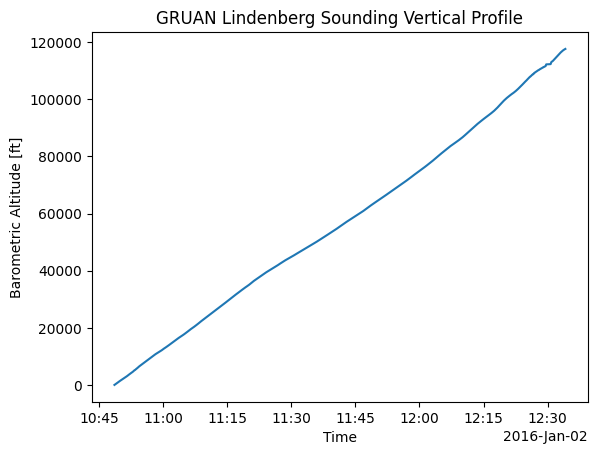

In [7]:
alt_ft.plot()
plt.xlabel("Time")
plt.ylabel("Barometric Altitude [ft]")
plt.title("GRUAN Lindenberg Sounding Vertical Profile")
plt.show()

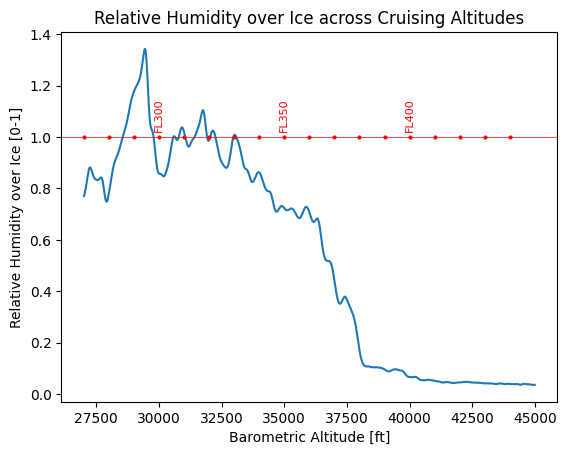

In [8]:
cond = (alt_ft >= 27000.0) & (alt_ft <= 45000.0)

plt.plot(alt_ft[cond], rhi[cond])
plt.xlabel("Barometric Altitude [ft]")
plt.ylabel("Relative Humidity over Ice [0-1]")
plt.title("Relative Humidity over Ice across Cruising Altitudes")
plt.axhline(1.0, color="red", label="RHi = 1", linewidth=0.5)
for FL in range(27000, 45000, 1000):
    plt.plot(FL, 1.0, "ro", markersize=2)
    if FL % 5000 == 0:
        plt.text(FL, 1.03, f"FL{FL // 100}", color="red", fontsize=8, ha="center", rotation=90)

plt.show()

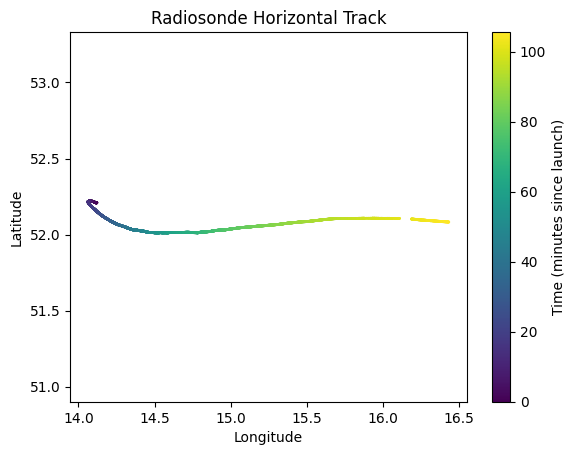

In [9]:
plt.scatter(ds["lon"], ds["lat"], c=(ds["time"] - ds["time"][0]).dt.total_seconds() / 60.0, s=1)

plt.colorbar(label="Time (minutes since launch)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Radiosonde Horizontal Track")
plt.axis("equal")
plt.show()

## Sounding Statistics

We can look at all soundings in 2016 and compute some interesting statistics:

- ISSR likelihood at each Flight Level (FL)
- Depth of thickest ISSR layer per sounding (as a simple measure of contrail avoidance difficulty)

This isn't meant to be comprehensive analysis, just a demonstration of possible uses of the GRUAN data for contrail studies.

In [10]:
FLs = np.arange(27000, 44000 + 1, 1000)  # FL270 to FL440


def rhi_at_FLs(ds: xr.Dataset) -> np.ndarray:
    """Compute RHi at specified FLs by interpolating from the GRUAN profile."""
    assert ds["press"].attrs["units"] == "hPa"
    assert ds["temp"].attrs["units"] == "K"
    assert ds["rh"].attrs["units"] == "1"

    T = ds["temp"]
    e_sw = thermo.e_sat_liquid(T)
    e_si = thermo.e_sat_ice(T)
    rhi = ds["rh"] * e_sw / e_si

    alt_ft = units.pl_to_ft(ds["press"])
    return np.interp(FLs, alt_ft, rhi)


def thickest_depth(issr: np.ndarray) -> int:
    """Compute the thickest continuous depth of supersaturation."""
    if not np.any(issr):
        return 0

    edges = np.diff(np.r_[False, issr, False].astype(int))
    start = np.flatnonzero(edges == 1)
    end = np.flatnonzero(edges == -1)
    return np.max(end - start).item()

In [11]:
files = gruan.list_files(2016)
files.sort()

depths = {}
issrs = {}
for file in tqdm(files):
    ds = gruan.get(file)
    rhi = rhi_at_FLs(ds)
    issr = rhi > 1.0

    depth = thickest_depth(issr)
    t = ds.attrs["g.Ascent.StandardTime"]

    depths[t] = depth
    issrs[t] = issr

depths_ser = pd.Series(depths)
issr_df = pd.DataFrame.from_dict(issrs, orient="index", columns=[f"FL{FL // 100}" for FL in FLs])

100%|██████████| 1201/1201 [00:26<00:00, 44.51it/s]


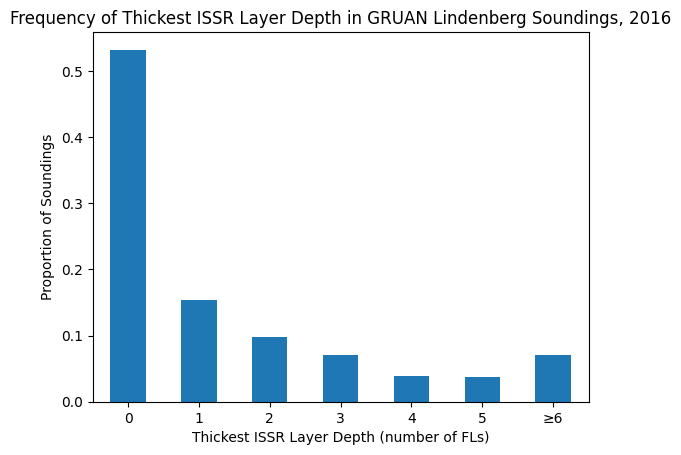

In [ ]:
depths_capped = depths_ser.where(depths_ser < 6, 6)

counts = depths_capped.value_counts().sort_index()
proportions = counts / counts.sum()

ax = proportions.plot(kind="bar")
ax.set_xlabel("Thickest ISSR Layer Depth (number of FLs)")
ax.set_ylabel("Proportion of Soundings")
ax.set_title("Frequency of Thickest ISSR Layer Depth in GRUAN Lindenberg Soundings, 2016")
xticklabels = [*range(6), "≥6"]
ax.set_xticklabels(xticklabels, rotation=0)
plt.show()

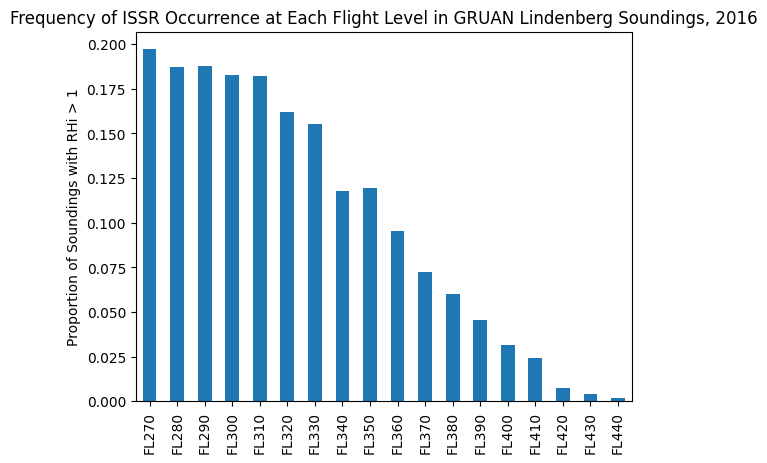

In [13]:
issr_df.mean(axis=0).plot(kind="bar")
plt.ylabel("Proportion of Soundings with RHi > 1")
plt.title("Frequency of ISSR Occurrence at Each Flight Level in GRUAN Lindenberg Soundings, 2016")
plt.show()

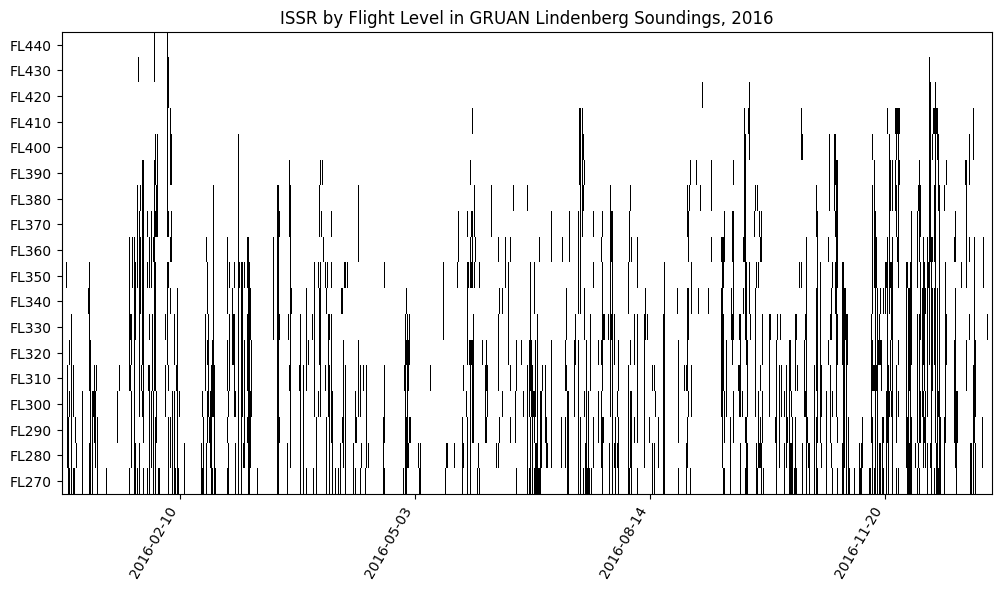

In [14]:
# There are some gaps in the time series which the plot below obfuscates, but
# they are small and infrequent.
plt.figure(figsize=(12, 6))
plt.imshow(issr_df.T[::-1], aspect="auto", cmap="Grays", interpolation="none")
plt.yticks(ticks=np.arange(len(FLs)), labels=[f"FL{FL // 100}" for FL in FLs[::-1]])
xticks = [150, 450, 750, 1050]
plt.xticks(ticks=xticks, labels=[issr_df.index[i][:10] for i in xticks], rotation=60, ha="right")
plt.title("ISSR by Flight Level in GRUAN Lindenberg Soundings, 2016")
plt.show()

## Run CoCiP over GRUAN Soundings

**EXPERIMENTAL**

In this section, we assume the atmosphere is constant horizontally and temporally over the duration of the contrail simulation, and only varies with altitude according to the GRUAN sounding. This is not realistic, but allows us to demonstrate how to simulate ice particle growth in contrails using high-quality GRUAN meteorological data via CoCiP (CoCiP was not designed for this use-case and it's unclear if the results are meaningful). This is not a rigorous study, but rather a demonstration of possible uses of the GRUAN data for contrail studies.

In [15]:
from pycontrails import GeoVectorDataset, MetDataset
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocipgrid import CocipGrid
from pycontrails.models.ps_model import PSGrid
from pycontrails.physics import constants

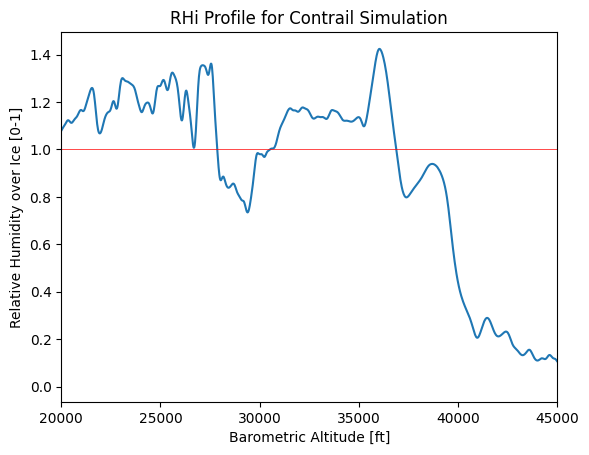

In [16]:
# Pull cherry-picked data (high RHi at cruise)
file = "LIN-RS-01_2_RS92-GDP_002_20160123T060000_1-000-001.nc"
ds = gruan.get(file)


# Compute RHi from RH and T
T = ds["temp"]
e_sw = thermo.e_sat_liquid(T)
e_si = thermo.e_sat_ice(T)
rhi = ds["rh"] * e_sw / e_si

# Compute barometric altitude from pressure
alt_ft = units.pl_to_ft(ds["press"])

plt.plot(alt_ft, rhi)
plt.xlabel("Barometric Altitude [ft]")
plt.ylabel("Relative Humidity over Ice [0-1]")
plt.title("RHi Profile for Contrail Simulation")
plt.axhline(1.0, color="red", label="RHi = 1", linewidth=0.5)
plt.xlim(20000, 45000)
plt.show()

In [17]:
# View available meteorological variables in GRUAN
for v in ds.data_vars:
    print(f"{v:14} {ds[v].attrs.get('standard_name', ''):44} {ds[v].attrs.get('long_name', '')}")

press          air_pressure                                 Pressure
temp           air_temperature                              Temperature
rh             relative_humidity                            Relative Humidity
wdir           wind_from_direction                          Wind Direction
wspeed         wind_speed                                   Wind Speed
geopot         geopotential_height                          Geopotential Altitude
u              eastward_wind                                Zonal Wind
v              northward_wind                               Meridional Wind
FP                                                          Frostpoint
WVMR           Water_vapor_mixing_ratio                     Water Vapor Volume Mixing Ratio
asc                                                         Ascent/Descent Speed
SWrad          short_wave_radiation                         Short wave radiation from model
u_SWrad        short_wave_radiation standard_error          Uncertaint

In [18]:
# Create Frankenstein gridded met from GRUAN data
# There are better ways to do this, but this suffices for demonstration purposes

t0 = pd.Timestamp(ds["time"][0].to_pandas()).floor("1h")
t1 = t0 + pd.Timedelta(hours=6)

lat0 = 50.0
lat1 = 55.0
lon0 = 14.0
lon1 = 20.0

level = ds["press"].values
cond = (level >= 150.0) & (level <= 500.0)
p = level[cond] * 100.0

T = ds["temp"].values[cond]
q = ds["rh"].values[cond] * thermo.e_sat_liquid(T) * constants.epsilon / p
u = ds["u"].values[cond]
v = ds["v"].values[cond]


ds_met = xr.Dataset(
    data_vars={
        "air_temperature": (("level",), T),
        "specific_humidity": (("level",), q),
        "eastward_wind": (("level",), u),
        "northward_wind": (("level",), v),
        "lagrangian_tendency_of_air_pressure": (("level",), np.zeros_like(level[cond])),  # mocked
        "tau_cirrus": (("level",), np.zeros_like(level[cond])),  # mocked
    },
    coords={
        "longitude": np.array([lon0, lon1]),
        "latitude": np.array([lat0, lat1]),
        "level": level[cond],
        "time": np.array([t0, t1], dtype="datetime64[ns]"),
    },
)

met = MetDataset(ds_met.broadcast_like(ds_met))
met

MetDataset with data:

<xarray.Dataset> Size: 253kB
Dimensions:                              (longitude: 2, latitude: 2,
                                          level: 1215, time: 2)
Coordinates:
  * longitude                            (longitude) float64 16B 14.0 20.0
  * latitude                             (latitude) float64 16B 50.0 55.0
  * level                                (level) float64 10kB 150.1 ... 499.9
  * time                                 (time) datetime64[ns] 16B 2016-01-23...
    air_pressure                         (level) float32 5kB 1.501e+04 ... 4....
    altitude                             (level) float32 5kB 1.361e+04 ... 5....
Data variables:
    air_temperature                      (longitude, latitude, level, time) float32 39kB ...
    specific_humidity                    (longitude, latitude, level, time) float32 39kB ...
    eastward_wind                        (longitude, latitude, level, time) float32 39kB ...
    northward_wind                       (longitude, latitude, level, time) float32 39kB ...
    lagrangian_tendency_of_air_pressure  (longitude, latitude, level, time) float32 39kB ...
    tau_cirrus                           (longitude, latitude, level, time) float32 39kB ...

In [19]:
# Download ERA5 rad data (radiative properties needed by CoCiP, but unused here)
era5 = ERA5(time=(t0, t1), variables=CocipGrid.ecmwf_rad_variables())
rad = era5.open_metdataset()
rad

MetDataset with data:

<xarray.Dataset> Size: 58MB
Dimensions:                    (level: 1, time: 7, latitude: 721,
                                longitude: 1440)
Coordinates:
  * level                      (level) float64 8B -1.0
  * time                       (time) datetime64[ns] 56B 2016-01-23T04:00:00 ...
  * latitude                   (latitude) float64 6kB -90.0 -89.75 ... 90.0
  * longitude                  (longitude) float64 12kB -180.0 -179.8 ... 179.8
    number                     int64 8B 0
    expver                     (time) <U4 112B dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    top_net_solar_radiation    (longitude, latitude, level, time) float32 29MB dask.array<chunksize=(1440, 721, 1, 1), meta=np.ndarray>
    top_net_thermal_radiation  (longitude, latitude, level, time) float32 29MB dask.array<chunksize=(1440, 721, 1, 1), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-17T13:10 GRIB to CDM+CF via cfgrib-0.9.1...
    pycontrails_version:     0.58.1.dev6
    provider:                ECMWF
    dataset:                 ERA5
    product:                 reanalysis

In [20]:
# Create model with fine time step
# We use the CocipGrid model here because waypoints are not part of any flight
cocip = CocipGrid(
    met=met,
    rad=rad,
    aircraft_performance=PSGrid(),
    dt_integration="1min",
    max_age="5h",
    show_progress=False,
    verbose_outputs_evolution=True,
    azimuth=None,
    segment_length=None,
)

# Sample the atmosphere at specified FLs
source = GeoVectorDataset(
    level=units.ft_to_pl(FLs),
    longitude=np.full_like(FLs, 15.0, dtype=float),
    latitude=np.full_like(FLs, 52.0, dtype=float),
    time=np.full_like(FLs, t0, dtype="datetime64[ns]"),
    aircraft_type="A320",
)

In [21]:
# Evaluate CoCiP
cocip.eval(source)
output = cocip.contrail

# Groupby specified FLs for convenience
source_FL = FLs[output["index"]] // 100
age_hours = (output["time"] - t0).dt.total_seconds() / 60.0 / 60.0
grouped = output.set_index(age_hours).groupby(source_FL)

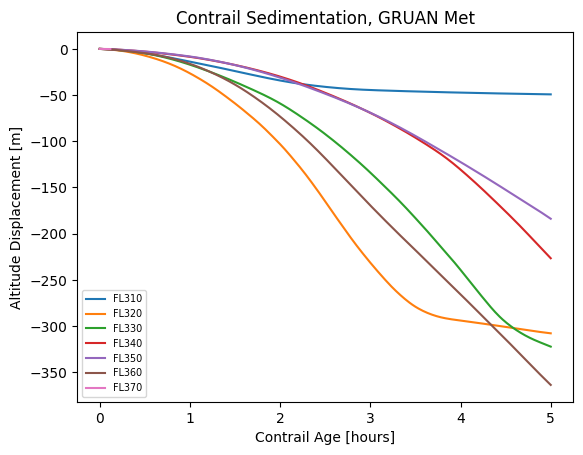

In [22]:
# Plot altitude evolution for each FL
# Contrails fall over time due to sedimentation
# (We assume no vertical air motion in this Frankenstein met)
for fl, alt_m in grouped["altitude"]:
    if len(alt_m) <= 5:
        continue
    (alt_m - alt_m[0]).plot(label=f"FL{fl}")

plt.legend(loc="lower left", fontsize="x-small")
plt.xlabel("Contrail Age [hours]")
plt.ylabel("Altitude Displacement [m]")
plt.title("Contrail Sedimentation, GRUAN Met")
plt.show()

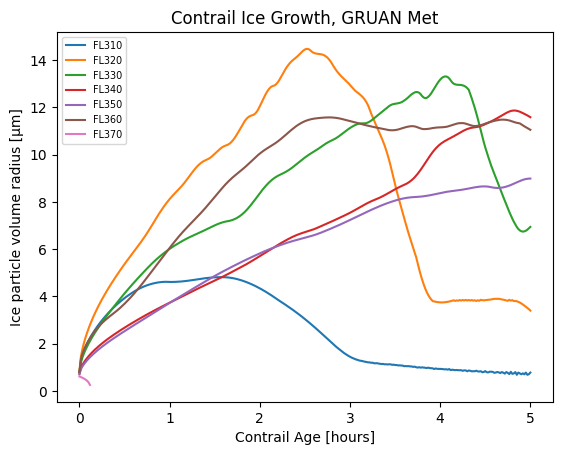

In [23]:
# Plot ice particle volume radius evolution for each FL
# Ice particles grow over time due to water vapor deposition in supersaturated conditions
for fl, r_ice_vol_m in grouped["r_ice_vol"]:
    if len(r_ice_vol_m) <= 5:
        continue
    r_ice_vol_um = 1e6 * r_ice_vol_m  # m -> µm
    r_ice_vol_um.plot(label=f"FL{fl}")

plt.legend(loc="upper left", fontsize="x-small")
plt.xlabel("Contrail Age [hours]")
plt.ylabel("Ice particle volume radius [µm]")
plt.title("Contrail Ice Growth, GRUAN Met")
plt.show()